In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import seaborn as sns
import matplotlib.pyplot as plt

import re, os
import unicodedata
import json

import nltk
import nltk.sentiment
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from time import strftime

from wordcloud import WordCloud

from pprint import pprint

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

import acquire

import spacy
pd.set_option('display.max_colwidth', None)



### Acquire data

We will be using the 1000 labeled notes in `test.csv`

In [2]:
# Load test data labels
df = pd.read_csv('train.csv')

In [3]:
df.head()

,id,case_num,pn_num,feature_num,annotation,location
0,00016_000,0,16,0,['dad with recent heart attcak'],['696 724']
1,00016_001,0,16,1,"['mom with ""thyroid disease']",['668 693']
2,00016_002,0,16,2,['chest pressure'],['203 217']
3,00016_003,0,16,3,"['intermittent episodes', 'episode']","['70 91', '176 183']"
4,00016_004,0,16,4,['felt as if he were going to pass out'],['222 258']


In [4]:
pd.set_option('display.max_rows', 1500)


In [5]:
df.shape

(14300, 6)

In [6]:
df.value_counts('feature_num')

feature_num
0      100
611    100
605    100
606    100
607    100
608    100
609    100
610    100
700    100
603    100
701    100
702    100
703    100
704    100
705    100
706    100
604    100
602    100
708    100
511    100
505    100
506    100
507    100
508    100
509    100
510    100
512    100
601    100
513    100
514    100
515    100
516    100
517    100
600    100
707    100
800    100
503    100
908    100
902    100
903    100
904    100
905    100
906    100
907    100
909    100
900    100
910    100
911    100
912    100
913    100
914    100
915    100
901    100
817    100
801    100
808    100
802    100
803    100
804    100
805    100
806    100
807    100
809    100
816    100
810    100
811    100
812    100
813    100
814    100
815    100
504    100
502    100
1      100
200    100
107    100
108    100
109    100
110    100
111    100
112    100
201    100
105    100
202    100
203    100
204    100
205    100
206    100
207    100
106    100
104    10

In [7]:
notes = pd.read_csv('patient_notes.csv')

In [8]:
notes.head()

,pn_num,case_num,pn_history
0,0,0,"17-year-old male, has come to the student health clinic complaining of heart pounding. Mr. Cleveland's mother has given verbal consent for a history, physical examination, and treatment\r\n-began 2-3 months ago,sudden,intermittent for 2 days(lasting 3-4 min),worsening,non-allev/aggrav\r\n-associated with dispnea on exersion and rest,stressed out about school\r\n-reports fe feels like his heart is jumping out of his chest\r\n-ros:denies chest pain,dyaphoresis,wt loss,chills,fever,nausea,vomiting,pedal edeam\r\n-pmh:non,meds :aderol (from a friend),nkda\r\n-fh:father had MI recently,mother has thyroid dz\r\n-sh:non-smoker,mariguana 5-6 months ago,3 beers on the weekend, basketball at school\r\n-sh:no std"
1,1,0,"17 yo male with recurrent palpitations for the past 3 mo lasting about 3 - 4 min, it happened about 5 - 6 times since the beginning. One time durign a baskeball game two days ago light headedness, pressure in the chest, catching breath, but no fainting. During teh episodes no sweating. No diarrhea, no heat intolerance, no weight loss. Has tried aterol to be able to better concentrate, has received it from his roommate. ."
2,2,0,"Dillon Cleveland is a 17 y.o. male patient with no significant PMH who presents with complaints of heart pounding. This has been going on for a few months and happens once or twice a month. He cannot think of any triggers, and it has occurred both with activity and at rest. Occasionally, it is accompanied by chest pressure but not pain that is located at the center of his chest. On one instance, he experienced chest pressure, lightheadedness and shortness of breath for 10 minutes with the heart pounding. \r\n\r\nOtherwise, he has not had shortness of breath, chest pain, anxiety, \r\n\r\nMedication: adderall twice a week as study aid (not prescribed)\r\nFH: mother - thyroid disease, father - heart attack at age 52, both living\r\nSH: no smoking; 3-4 drinks on the weekend per sitting; marijuanna once recently, no other recreational drugs"
3,3,0,"a 17 yo m c/o palpitation started 3 mos ago; \r\nNOTHING IMPROVES OR EXACERBATES THE SYMPTOMS ACCORDING TO HIM; IT CAN HAPPEN ANY TIME; MAY TAKE A FEW MINUTES; LAST TIME HAPPENED 2 DAYS AGO DURING PLAYING A GAME AND IT WAS ASSOCIATED WITH RETROSTERNAL PRESSURE LIKE DISCOMFORT; AND HE FELT LIGHTHEADED. BUT HE DID NOT LOSE CONCIOUSNESS AND DID NOT FALL. \r\nNOT ASSOCIATED WITH NAUSEA VOMITING; HEADACHE; ABDOMINAL PAIN; CHANGES IN URINATION OR BOWEL HABITS, OR TREMOR OR SKIN OR HAIR CHANGE OR INTOLERABC\r\n\r\nPMH NONE\r\nPSHH: NONE\r\nMEDS: ADEROL TO STAY AWAKE\r\nHOSP: NONE\r\nFH: MOTHER HAS THYROID DISEASE; FATHER HAS CAD X 1 YR\r\nSH: NO SMOKING; DRINKING ON WEEKENDS CAGE 0/4; ONE TIME USE OF MARIJUANA\r\n\r\n\r\n"
4,4,0,"17yo male with no pmh here for evaluation of palpitations. States for the last 3-4mo he has felt that his heart with intermittently ""beat out of his chest,"" with some associated difficulty catching his breath. States that the most recent event was 2 days ago, and during activity at a soccer game. He does not seem to note any specific precipitatinig factors at this time. He also states that he feels as if he will faint during these events, but has not lost consciousness at any point. Furthermore, he does endorse theses attacks occuring 1-2 times a month and peak at 4 mins. He denies any stressors at home. ROS: denies weight loss, fevers, recnet illness, change in bowel habits. PMH: negative, PSH negative, FHX mom with thyroid disorder, dad with heart condition and MI at 52yo. SHX no tobacco, ETOH on weekends, Marijuana tried a month ago. Med: is taking some of roommates Adderoll intermittently (last was 2 days ago prior to event). KNDA"


In [9]:
df = df.merge(notes, how='inner', on='pn_num')

In [10]:
notes.shape

(42146, 3)

In [11]:
df.shape

(14300, 8)

In [12]:
notes.head()

,pn_num,case_num,pn_history
0,0,0,"17-year-old male, has come to the student health clinic complaining of heart pounding. Mr. Cleveland's mother has given verbal consent for a history, physical examination, and treatment\r\n-began 2-3 months ago,sudden,intermittent for 2 days(lasting 3-4 min),worsening,non-allev/aggrav\r\n-associated with dispnea on exersion and rest,stressed out about school\r\n-reports fe feels like his heart is jumping out of his chest\r\n-ros:denies chest pain,dyaphoresis,wt loss,chills,fever,nausea,vomiting,pedal edeam\r\n-pmh:non,meds :aderol (from a friend),nkda\r\n-fh:father had MI recently,mother has thyroid dz\r\n-sh:non-smoker,mariguana 5-6 months ago,3 beers on the weekend, basketball at school\r\n-sh:no std"
1,1,0,"17 yo male with recurrent palpitations for the past 3 mo lasting about 3 - 4 min, it happened about 5 - 6 times since the beginning. One time durign a baskeball game two days ago light headedness, pressure in the chest, catching breath, but no fainting. During teh episodes no sweating. No diarrhea, no heat intolerance, no weight loss. Has tried aterol to be able to better concentrate, has received it from his roommate. ."
2,2,0,"Dillon Cleveland is a 17 y.o. male patient with no significant PMH who presents with complaints of heart pounding. This has been going on for a few months and happens once or twice a month. He cannot think of any triggers, and it has occurred both with activity and at rest. Occasionally, it is accompanied by chest pressure but not pain that is located at the center of his chest. On one instance, he experienced chest pressure, lightheadedness and shortness of breath for 10 minutes with the heart pounding. \r\n\r\nOtherwise, he has not had shortness of breath, chest pain, anxiety, \r\n\r\nMedication: adderall twice a week as study aid (not prescribed)\r\nFH: mother - thyroid disease, father - heart attack at age 52, both living\r\nSH: no smoking; 3-4 drinks on the weekend per sitting; marijuanna once recently, no other recreational drugs"
3,3,0,"a 17 yo m c/o palpitation started 3 mos ago; \r\nNOTHING IMPROVES OR EXACERBATES THE SYMPTOMS ACCORDING TO HIM; IT CAN HAPPEN ANY TIME; MAY TAKE A FEW MINUTES; LAST TIME HAPPENED 2 DAYS AGO DURING PLAYING A GAME AND IT WAS ASSOCIATED WITH RETROSTERNAL PRESSURE LIKE DISCOMFORT; AND HE FELT LIGHTHEADED. BUT HE DID NOT LOSE CONCIOUSNESS AND DID NOT FALL. \r\nNOT ASSOCIATED WITH NAUSEA VOMITING; HEADACHE; ABDOMINAL PAIN; CHANGES IN URINATION OR BOWEL HABITS, OR TREMOR OR SKIN OR HAIR CHANGE OR INTOLERABC\r\n\r\nPMH NONE\r\nPSHH: NONE\r\nMEDS: ADEROL TO STAY AWAKE\r\nHOSP: NONE\r\nFH: MOTHER HAS THYROID DISEASE; FATHER HAS CAD X 1 YR\r\nSH: NO SMOKING; DRINKING ON WEEKENDS CAGE 0/4; ONE TIME USE OF MARIJUANA\r\n\r\n\r\n"
4,4,0,"17yo male with no pmh here for evaluation of palpitations. States for the last 3-4mo he has felt that his heart with intermittently ""beat out of his chest,"" with some associated difficulty catching his breath. States that the most recent event was 2 days ago, and during activity at a soccer game. He does not seem to note any specific precipitatinig factors at this time. He also states that he feels as if he will faint during these events, but has not lost consciousness at any point. Furthermore, he does endorse theses attacks occuring 1-2 times a month and peak at 4 mins. He denies any stressors at home. ROS: denies weight loss, fevers, recnet illness, change in bowel habits. PMH: negative, PSH negative, FHX mom with thyroid disorder, dad with heart condition and MI at 52yo. SHX no tobacco, ETOH on weekends, Marijuana tried a month ago. Med: is taking some of roommates Adderoll intermittently (last was 2 days ago prior to event). KNDA"


In [13]:
df.head()

,id,case_num_x,pn_num,feature_num,annotation,location,case_num_y,pn_history
0,00016_000,0,16,0,['dad with recent heart attcak'],['696 724'],0,"HPI: 17yo M presents with palpitations. Patient reports 3-4 months of intermittent episodes of ""heart beating/pounding out of my chest."" 2 days ago during a soccer game had an episode, but this time had chest pressure and felt as if he were going to pass out (did not lose conciousness). Of note patient endorses abusing adderall, primarily to study (1-3 times per week). Before recent soccer game, took adderrall night before and morning of game. Denies shortness of breath, diaphoresis, fevers, chills, headache, fatigue, changes in sleep, changes in vision/hearing, abdominal paun, changes in bowel or urinary habits. \r\nPMHx: none\r\nRx: uses friends adderrall\r\nFHx: mom with ""thyroid disease,"" dad with recent heart attcak\r\nAll: none\r\nImmunizations: up to date\r\nSHx: Freshmen in college. Endorses 3-4 drinks 3 nights / week (on weekends), denies tabacco, endorses trying marijuana. Sexually active with girlfriend x 1 year, uses condoms"
1,00016_001,0,16,1,"['mom with ""thyroid disease']",['668 693'],0,"HPI: 17yo M presents with palpitations. Patient reports 3-4 months of intermittent episodes of ""heart beating/pounding out of my chest."" 2 days ago during a soccer game had an episode, but this time had chest pressure and felt as if he were going to pass out (did not lose conciousness). Of note patient endorses abusing adderall, primarily to study (1-3 times per week). Before recent soccer game, took adderrall night before and morning of game. Denies shortness of breath, diaphoresis, fevers, chills, headache, fatigue, changes in sleep, changes in vision/hearing, abdominal paun, changes in bowel or urinary habits. \r\nPMHx: none\r\nRx: uses friends adderrall\r\nFHx: mom with ""thyroid disease,"" dad with recent heart attcak\r\nAll: none\r\nImmunizations: up to date\r\nSHx: Freshmen in college. Endorses 3-4 drinks 3 nights / week (on weekends), denies tabacco, endorses trying marijuana. Sexually active with girlfriend x 1 year, uses condoms"
2,00016_002,0,16,2,['chest pressure'],['203 217'],0,"HPI: 17yo M presents with palpitations. Patient reports 3-4 months of intermittent episodes of ""heart beating/pounding out of my chest."" 2 days ago during a soccer game had an episode, but this time had chest pressure and felt as if he were going to pass out (did not lose conciousness). Of note patient endorses abusing adderall, primarily to study (1-3 times per week). Before recent soccer game, took adderrall night before and morning of game. Denies shortness of breath, diaphoresis, fevers, chills, headache, fatigue, changes in sleep, changes in vision/hearing, abdominal paun, changes in bowel or urinary habits. \r\nPMHx: none\r\nRx: uses friends adderrall\r\nFHx: mom with ""thyroid disease,"" dad with recent heart attcak\r\nAll: none\r\nImmunizations: up to date\r\nSHx: Freshmen in college. Endorses 3-4 drinks 3 nights / week (on weekends), denies tabacco, endorses trying marijuana. Sexually active with girlfriend x 1 year, uses condoms"
3,00016_003,0,16,3,"['intermittent episodes', 'episode']","['70 91', '176 183']",0,"HPI: 17yo M presents with palpitations. Patient reports 3-4 months of intermittent episodes of ""heart beating/pounding out of my chest."" 2 days ago during a soccer game had an episode, but this time had chest pressure and felt as if he were going to pass out (did not lose conciousness). Of note patient endorses abusing adderall, primarily to study (1-3 times per week). Before recent soccer game, took adderrall night before and morning of game. Denies shortness of breath, diaphoresis, fevers, chills, headache, fatigue, changes in sleep, changes in vision/hearing, abdominal paun, changes in bowel or urinary habits. \r\nPMHx: none\r\nRx: uses friends adderrall\r\nFHx: mom with ""thyroid disease,"" dad with recent heart attcak\r\nAll: none\r\nImmunizations: up to date\r\nSHx: 

In [14]:
import prepare_jag

In [15]:
df.head()

,id,case_num_x,pn_num,feature_num,annotation,location,case_num_y,pn_history
0,00016_000,0,16,0,['dad with recent heart attcak'],['696 724'],0,"HPI: 17yo M presents with palpitations. Patient reports 3-4 months of intermittent episodes of ""heart beating/pounding out of my chest."" 2 days ago during a soccer game had an episode, but this time had chest pressure and felt as if he were going to pass out (did not lose conciousness). Of note patient endorses abusing adderall, primarily to study (1-3 times per week). Before recent soccer game, took adderrall night before and morning of game. Denies shortness of breath, diaphoresis, fevers, chills, headache, fatigue, changes in sleep, changes in vision/hearing, abdominal paun, changes in bowel or urinary habits. \r\nPMHx: none\r\nRx: uses friends adderrall\r\nFHx: mom with ""thyroid disease,"" dad with recent heart attcak\r\nAll: none\r\nImmunizations: up to date\r\nSHx: Freshmen in college. Endorses 3-4 drinks 3 nights / week (on weekends), denies tabacco, endorses trying marijuana. Sexually active with girlfriend x 1 year, uses condoms"
1,00016_001,0,16,1,"['mom with ""thyroid disease']",['668 693'],0,"HPI: 17yo M presents with palpitations. Patient reports 3-4 months of intermittent episodes of ""heart beating/pounding out of my chest."" 2 days ago during a soccer game had an episode, but this time had chest pressure and felt as if he were going to pass out (did not lose conciousness). Of note patient endorses abusing adderall, primarily to study (1-3 times per week). Before recent soccer game, took adderrall night before and morning of game. Denies shortness of breath, diaphoresis, fevers, chills, headache, fatigue, changes in sleep, changes in vision/hearing, abdominal paun, changes in bowel or urinary habits. \r\nPMHx: none\r\nRx: uses friends adderrall\r\nFHx: mom with ""thyroid disease,"" dad with recent heart attcak\r\nAll: none\r\nImmunizations: up to date\r\nSHx: Freshmen in college. Endorses 3-4 drinks 3 nights / week (on weekends), denies tabacco, endorses trying marijuana. Sexually active with girlfriend x 1 year, uses condoms"
2,00016_002,0,16,2,['chest pressure'],['203 217'],0,"HPI: 17yo M presents with palpitations. Patient reports 3-4 months of intermittent episodes of ""heart beating/pounding out of my chest."" 2 days ago during a soccer game had an episode, but this time had chest pressure and felt as if he were going to pass out (did not lose conciousness). Of note patient endorses abusing adderall, primarily to study (1-3 times per week). Before recent soccer game, took adderrall night before and morning of game. Denies shortness of breath, diaphoresis, fevers, chills, headache, fatigue, changes in sleep, changes in vision/hearing, abdominal paun, changes in bowel or urinary habits. \r\nPMHx: none\r\nRx: uses friends adderrall\r\nFHx: mom with ""thyroid disease,"" dad with recent heart attcak\r\nAll: none\r\nImmunizations: up to date\r\nSHx: Freshmen in college. Endorses 3-4 drinks 3 nights / week (on weekends), denies tabacco, endorses trying marijuana. Sexually active with girlfriend x 1 year, uses condoms"
3,00016_003,0,16,3,"['intermittent episodes', 'episode']","['70 91', '176 183']",0,"HPI: 17yo M presents with palpitations. Patient reports 3-4 months of intermittent episodes of ""heart beating/pounding out of my chest."" 2 days ago during a soccer game had an episode, but this time had chest pressure and felt as if he were going to pass out (did not lose conciousness). Of note patient endorses abusing adderall, primarily to study (1-3 times per week). Before recent soccer game, took adderrall night before and morning of game. Denies shortness of breath, diaphoresis, fevers, chills, headache, fatigue, changes in sleep, changes in vision/hearing, abdominal paun, changes in bowel or urinary habits. \r\nPMHx: none\r\nRx: uses friends adderrall\r\nFHx: mom with ""thyroid disease,"" dad with recent heart attcak\r\nAll: none\r\nImmunizations: up to date\r\nSHx: 

In [18]:
df.head()

,id,case_num_x,pn_num,feature_num,annotation,location,case_num_y,original
0,00016_000,0,16,0,['dad with recent heart attcak'],['696 724'],0,"HPI: 17yo M presents with palpitations. Patient reports 3-4 months of intermittent episodes of ""heart beating/pounding out of my chest."" 2 days ago during a soccer game had an episode, but this time had chest pressure and felt as if he were going to pass out (did not lose conciousness). Of note patient endorses abusing adderall, primarily to study (1-3 times per week). Before recent soccer game, took adderrall night before and morning of game. Denies shortness of breath, diaphoresis, fevers, chills, headache, fatigue, changes in sleep, changes in vision/hearing, abdominal paun, changes in bowel or urinary habits. \r\nPMHx: none\r\nRx: uses friends adderrall\r\nFHx: mom with ""thyroid disease,"" dad with recent heart attcak\r\nAll: none\r\nImmunizations: up to date\r\nSHx: Freshmen in college. Endorses 3-4 drinks 3 nights / week (on weekends), denies tabacco, endorses trying marijuana. Sexually active with girlfriend x 1 year, uses condoms"
1,00016_001,0,16,1,"['mom with ""thyroid disease']",['668 693'],0,"HPI: 17yo M presents with palpitations. Patient reports 3-4 months of intermittent episodes of ""heart beating/pounding out of my chest."" 2 days ago during a soccer game had an episode, but this time had chest pressure and felt as if he were going to pass out (did not lose conciousness). Of note patient endorses abusing adderall, primarily to study (1-3 times per week). Before recent soccer game, took adderrall night before and morning of game. Denies shortness of breath, diaphoresis, fevers, chills, headache, fatigue, changes in sleep, changes in vision/hearing, abdominal paun, changes in bowel or urinary habits. \r\nPMHx: none\r\nRx: uses friends adderrall\r\nFHx: mom with ""thyroid disease,"" dad with recent heart attcak\r\nAll: none\r\nImmunizations: up to date\r\nSHx: Freshmen in college. Endorses 3-4 drinks 3 nights / week (on weekends), denies tabacco, endorses trying marijuana. Sexually active with girlfriend x 1 year, uses condoms"
2,00016_002,0,16,2,['chest pressure'],['203 217'],0,"HPI: 17yo M presents with palpitations. Patient reports 3-4 months of intermittent episodes of ""heart beating/pounding out of my chest."" 2 days ago during a soccer game had an episode, but this time had chest pressure and felt as if he were going to pass out (did not lose conciousness). Of note patient endorses abusing adderall, primarily to study (1-3 times per week). Before recent soccer game, took adderrall night before and morning of game. Denies shortness of breath, diaphoresis, fevers, chills, headache, fatigue, changes in sleep, changes in vision/hearing, abdominal paun, changes in bowel or urinary habits. \r\nPMHx: none\r\nRx: uses friends adderrall\r\nFHx: mom with ""thyroid disease,"" dad with recent heart attcak\r\nAll: none\r\nImmunizations: up to date\r\nSHx: Freshmen in college. Endorses 3-4 drinks 3 nights / week (on weekends), denies tabacco, endorses trying marijuana. Sexually active with girlfriend x 1 year, uses condoms"
3,00016_003,0,16,3,"['intermittent episodes', 'episode']","['70 91', '176 183']",0,"HPI: 17yo M presents with palpitations. Patient reports 3-4 months of intermittent episodes of ""heart beating/pounding out of my chest."" 2 days ago during a soccer game had an episode, but this time had chest pressure and felt as if he were going to pass out (did not lose conciousness). Of note patient endorses abusing adderall, primarily to study (1-3 times per week). Before recent soccer game, took adderrall night before and morning of game. Denies shortness of breath, diaphoresis, fevers, chills, headache, fatigue, changes in sleep, changes in vision/hearing, abdominal paun, changes in bowel or urinary habits. \r\nPMHx: none\r\nRx: uses friends adderrall\r\nFHx: mom with ""thyroid disease,"" dad with recent heart attcak\r\nAll: none\r\nImmunizations: up to date\r\nSHx: Fr

In [16]:
    df.rename(columns={'pn_history': 'original'}, inplace=True)


In [19]:
df = prepare_jag.prep_article_data(df, 'original', extra_words=[], exclude_words=['no'])


Renamed 'pn_history' column to 'original'
Added a basic clean column lowercaseing and removing special characters
Added stemmed column with tokenized words and stopwords removed
Added lemmatized column with lemmatized words and stopwords removed
Data preparation complete


In [29]:
df.head(1)


,id,case_num_x,pn_num,feature_num,annotation,location,case_num_y,original,clean,stemmed,lemmatized
0,00016_000,0,16,0,['dad with recent heart attcak'],['696 724'],0,"HPI: 17yo M presents with palpitations. Patient reports 3-4 months of intermittent episodes of ""heart beating/pounding out of my chest."" 2 days ago during a soccer game had an episode, but this time had chest pressure and felt as if he were going to pass out (did not lose conciousness). Of note patient endorses abusing adderall, primarily to study (1-3 times per week). Before recent soccer game, took adderrall night before and morning of game. Denies shortness of breath, diaphoresis, fevers, chills, headache, fatigue, changes in sleep, changes in vision/hearing, abdominal paun, changes in bowel or urinary habits. \r\nPMHx: none\r\nRx: uses friends adderrall\r\nFHx: mom with ""thyroid disease,"" dad with recent heart attcak\r\nAll: none\r\nImmunizations: up to date\r\nSHx: Freshmen in college. Endorses 3-4 drinks 3 nights / week (on weekends), denies tabacco, endorses trying marijuana. Sexually active with girlfriend x 1 year, uses condoms",hpi 17yo presents palpitations patient reports 34 months intermittent episodes heart beatingpounding chest 2 days ago soccer game episode time chest pressure felt going pass lose conciousness note patient endorses abusing adderall primarily study 13 times per week recent soccer game took adderrall night morning game denies shortness breath diaphoresis fevers chills headache fatigue changes sleep changes visionhearing abdominal paun changes bowel urinary habits pmhx none rx uses friends adderrall fhx mom thyroid disease dad recent heart attcak none immunizations date shx freshmen college endorses 34 drinks 3 nights week weekends denies tabacco endorses trying marijuana sexually active girlfriend x 1 year uses condoms,hpi 17yo present palpit patient report 34 month intermitt episod heart beatingpound chest 2 day ago dure soccer game episod thi time chest pressur felt go pass lose concious note patient endors abus adderal primarili studi 13 time per week befor recent soccer game took adderral night befor morn game deni short breath diaphoresi fever chill headach fatigu chang sleep chang visionhear abdomin paun chang bowel urinari habit pmhx none rx use friend adderral fhx mom thyroid diseas dad recent heart attcak none immun date shx freshmen colleg endors 34 drink 3 night week weekend deni tabacco endors tri marijuana sexual activ girlfriend x 1 year use condom,hpi 17yo present palpitation patient report 34 month intermittent episode heart beatingpounding chest 2 day ago soccer game episode time chest pressure felt going pas lose conciousness note patient endorses abusing adderall primarily study 13 time per week recent soccer game took adderrall night morning game denies shortness breath diaphoresis fever chill headache fatigue change sleep change visionhearing abdominal paun change bowel urinary habit pmhx none rx us friend adderrall fhx mom thyroid disease dad recent heart attcak none immunization date shx freshman college endorses 34 drink 3 night week weekend denies tabacco endorses trying marijuana sexually active girlfriend x 1 year us condom


---

In [22]:
df.case_num_x.value_counts().sor

5    1800
8    1800
2    1700
9    1700
3    1600
0    1300
1    1300
6    1200
4    1000
7     900
Name: case_num_x, dtype: int64

In [26]:
# Look at distribution of cases
cases = pd.concat([df.case_num_x.value_counts(), df.case_num_x.value_counts(normalize = True)], axis = 1)
cases.columns = ['n', 'percent']
cases

,n,percent
5,1800,0.125874
8,1800,0.125874
2,1700,0.118881
9,1700,0.118881
3,1600,0.111888
0,1300,0.090909
1,1300,0.090909
6,1200,0.083916
4,1000,0.069930
7,900,0.062937


<AxesSubplot:ylabel='n'>

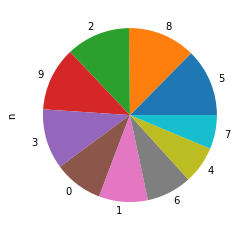

In [27]:
cases.n.plot.pie()

Make word lists by case from lemmatized words



In [30]:
df.head(1)

,id,case_num_x,pn_num,feature_num,annotation,location,case_num_y,original,clean,stemmed,lemmatized
0,00016_000,0,16,0,['dad with recent heart attcak'],['696 724'],0,"HPI: 17yo M presents with palpitations. Patient reports 3-4 months of intermittent episodes of ""heart beating/pounding out of my chest."" 2 days ago during a soccer game had an episode, but this time had chest pressure and felt as if he were going to pass out (did not lose conciousness). Of note patient endorses abusing adderall, primarily to study (1-3 times per week). Before recent soccer game, took adderrall night before and morning of game. Denies shortness of breath, diaphoresis, fevers, chills, headache, fatigue, changes in sleep, changes in vision/hearing, abdominal paun, changes in bowel or urinary habits. \r\nPMHx: none\r\nRx: uses friends adderrall\r\nFHx: mom with ""thyroid disease,"" dad with recent heart attcak\r\nAll: none\r\nImmunizations: up to date\r\nSHx: Freshmen in college. Endorses 3-4 drinks 3 nights / week (on weekends), denies tabacco, endorses trying marijuana. Sexually active with girlfriend x 1 year, uses condoms",hpi 17yo presents palpitations patient reports 34 months intermittent episodes heart beatingpounding chest 2 days ago soccer game episode time chest pressure felt going pass lose conciousness note patient endorses abusing adderall primarily study 13 times per week recent soccer game took adderrall night morning game denies shortness breath diaphoresis fevers chills headache fatigue changes sleep changes visionhearing abdominal paun changes bowel urinary habits pmhx none rx uses friends adderrall fhx mom thyroid disease dad recent heart attcak none immunizations date shx freshmen college endorses 34 drinks 3 nights week weekends denies tabacco endorses trying marijuana sexually active girlfriend x 1 year uses condoms,hpi 17yo present palpit patient report 34 month intermitt episod heart beatingpound chest 2 day ago dure soccer game episod thi time chest pressur felt go pass lose concious note patient endors abus adderal primarili studi 13 time per week befor recent soccer game took adderral night befor morn game deni short breath diaphoresi fever chill headach fatigu chang sleep chang visionhear abdomin paun chang bowel urinari habit pmhx none rx use friend adderral fhx mom thyroid diseas dad recent heart attcak none immun date shx freshmen colleg endors 34 drink 3 night week weekend deni tabacco endors tri marijuana sexual activ girlfriend x 1 year use condom,hpi 17yo present palpitation patient report 34 month intermittent episode heart beatingpounding chest 2 day ago soccer game episode time chest pressure felt going pas lose conciousness note patient endorses abusing adderall primarily study 13 time per week recent soccer game took adderrall night morning game denies shortness breath diaphoresis fever chill headache fatigue change sleep change visionhearing abdominal paun change bowel urinary habit pmhx none rx us friend adderrall fhx mom thyroid disease dad recent heart attcak none immunization date shx freshman college endorses 34 drink 3 night week weekend denies tabacco endorses trying marijuana sexually active girlfriend x 1 year us condom


In [31]:
#Make word lists by case_num_xs from lemmatized words
case0_words = ' '.join(df[df.case_num_x == 0].lemmatized).split()
case1_words = ' '.join(df[df.case_num_x == 1].lemmatized).split()
case2_words = ' '.join(df[df.case_num_x == 2].lemmatized).split()
case3_words = ' '.join(df[df.case_num_x == 3].lemmatized).split()
case4_words = ' '.join(df[df.case_num_x == 4].lemmatized).split()
case5_words = ' '.join(df[df.case_num_x == 5].lemmatized).split()
case6_words = ' '.join(df[df.case_num_x == 6].lemmatized).split()
case7_words = ' '.join(df[df.case_num_x == 7].lemmatized).split()
case8_words = ' '.join(df[df.case_num_x == 8].lemmatized).split()
case9_words = ' '.join(df[df.case_num_x == 9].lemmatized).split()
all_words = ' '.join(df.lemmatized).split()


In [32]:
# Look at word list lengths
print('Case0 words: '+str(len(case0_words)))
print('Case1 words: '+str(len(case1_words)))
print('Case2 words: '+str(len(case2_words)))
print('Case3 words: '+str(len(case3_words)))
print('Case4 words: '+str(len(case4_words)))
print('Case5 words: '+str(len(case5_words)))
print('Case6 words: '+str(len(case6_words)))
print('Case7 words: '+str(len(case7_words)))
print('Case8 words: '+str(len(case8_words)))
print('Case9 words: '+str(len(case9_words)))
print('All words: '+str(len(all_words)))

Case0 words: 126295
Case1 words: 128713
Case2 words: 177259
Case3 words: 152768
Case4 words: 93720
Case5 words: 175482
Case6 words: 115464
Case7 words: 94122
Case8 words: 184482
Case9 words: 149362
All words: 1397667


In [33]:
# Calculate word frequencies
case0_freq = pd.Series(case0_words).value_counts()
case1_freq = pd.Series(case1_words).value_counts()
case2_freq = pd.Series(case2_words).value_counts()
case3_freq = pd.Series(case3_words).value_counts()
case4_freq = pd.Series(case4_words).value_counts()
case5_freq = pd.Series(case5_words).value_counts()
case6_freq = pd.Series(case6_words).value_counts()
case7_freq = pd.Series(case7_words).value_counts()
case8_freq = pd.Series(case8_words).value_counts()
case9_freq = pd.Series(case9_words).value_counts()
all_freq = pd.Series(all_words).value_counts()

In [34]:
# Look at 20 most common words
word_counts = (pd.concat([all_freq, case0_freq, case1_freq, case2_freq, case3_freq, case4_freq, case5_freq, case6_freq, case7_freq, case8_freq, case9_freq], axis = 1, sort = True)
                .set_axis(['all', 'Case0', 'Case1', 'Case2', 'Case3', 'Case4', 'Case5', 'Case6', 'Case7', 'Case8', 'Case9'], axis = 1, inplace = False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))
word_counts.sort_values(by = 'all', ascending = False).head(20)

,all,Case0,Case1,Case2,Case3,Case4,Case5,Case6,Case7,Case8,Case9
no,44027,3458,4511,5729,5824,2650,6246,2772,3366,4932,4539
ha,26941,2210,2548,3060,2832,2060,2448,1632,1809,4500,3842
pain,24710,819,4992,1445,7376,530,1062,4380,792,594,2720
denies,17903,1859,1508,2176,1680,1590,2088,1596,1098,2268,2040
none,17403,1664,2119,1207,1904,1330,3618,972,1692,738,2159
ago,16811,1248,2626,2703,848,630,4122,780,1278,1998,578
week,14946,793,988,1428,1888,1540,3780,156,306,2826,1241
day,13993,871,2015,3366,784,440,1260,1500,1458,1296,1003
change,12452,1378,520,2278,1040,1250,1530,672,1161,1620,1003
2,12241,715,1456,2278,2336,430,2106,216,1431,270,1003


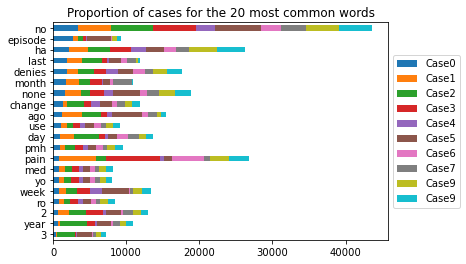

In [35]:
# figure out the percentage of language in words
(word_counts
 .assign(p_case0 = word_counts.Case0 / word_counts['all'],
        p_case1 = word_counts.Case1 / word_counts['all'],
        p_case2 = word_counts.Case2 / word_counts['all'],
        p_case3 = word_counts.Case3 / word_counts['all'],
        p_case4 = word_counts.Case4 / word_counts['all'],
        p_case5 = word_counts.Case5 / word_counts['all'],
        p_case6 = word_counts.Case6 / word_counts['all'],
        p_case7 = word_counts.Case7 / word_counts['all'],
        p_case8 = word_counts.Case8 / word_counts['all'],
        p_case9 = word_counts.Case9 / word_counts['all'])
        
 .sort_values(by = 'all')
 [['Case0', 'Case1', 'Case2', 'Case3', 'Case4', 'Case5', 'Case6', 'Case7', 'Case9', 'Case9']]
 .tail(20)
 .sort_values('Case0')
 .plot.barh(stacked=True))

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.title('Proportion of cases for the 20 most common words');

### Look at bigrams by case

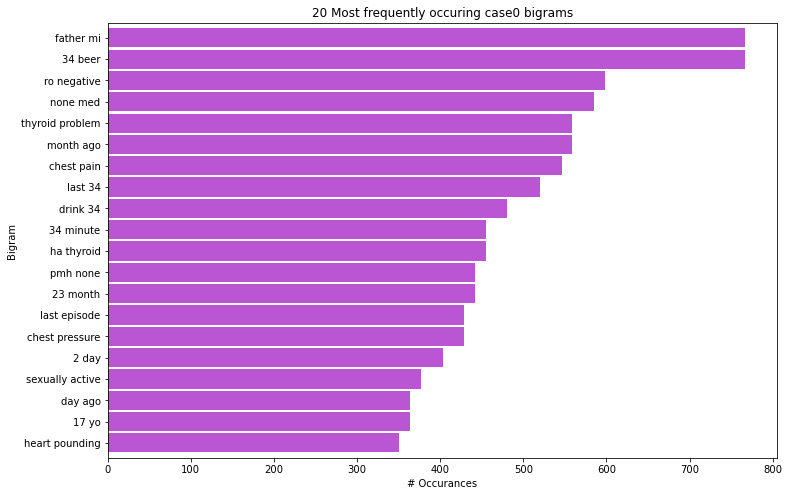

In [36]:
# Calculate Case 0bigrams
case0_bigrams = (pd.Series(nltk.ngrams(case0_words, 2))
                      .value_counts()
                      .head(20))
# Vizualize top case0 Bigrams
case0_bigrams.sort_values().plot.barh(color = 'mediumorchid', width=.9, figsize=(12, 8))

plt.title('20 Most frequently occuring case0 bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = case0_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

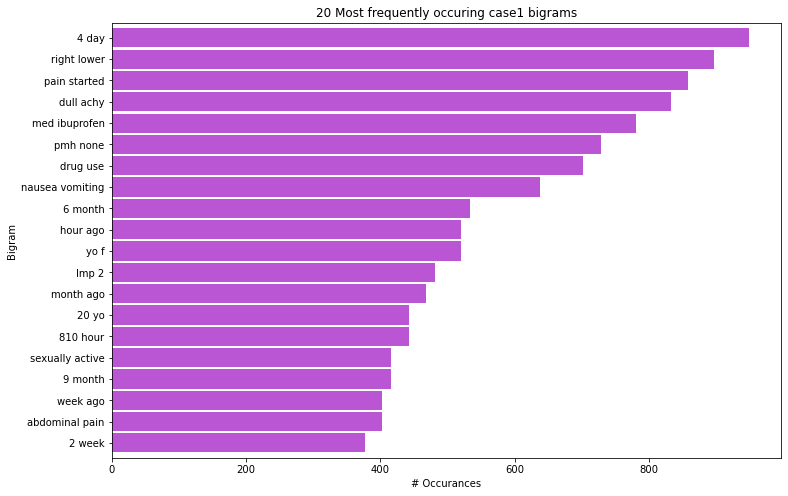

In [37]:
# Calculate Case 0bigrams
case1_bigrams = (pd.Series(nltk.ngrams(case1_words, 2))
                      .value_counts()
                      .head(20))
# Vizualize top case1 Bigrams
case1_bigrams.sort_values().plot.barh(color = 'mediumorchid', width=.9, figsize=(12, 8))

plt.title('20 Most frequently occuring case1 bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = case1_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

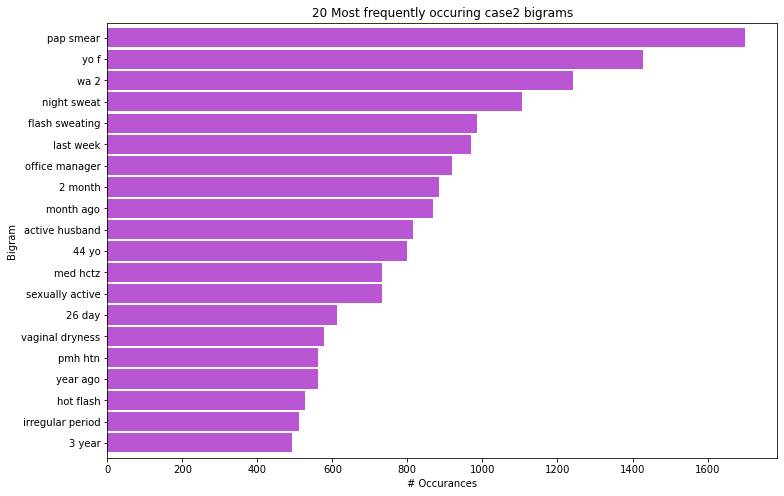

In [38]:
# Calculate Case 0bigrams
case2_bigrams = (pd.Series(nltk.ngrams(case2_words, 2))
                      .value_counts()
                      .head(20))
# Vizualize top case2 Bigrams
case2_bigrams.sort_values().plot.barh(color = 'mediumorchid', width=.9, figsize=(12, 8))

plt.title('20 Most frequently occuring case2 bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = case2_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

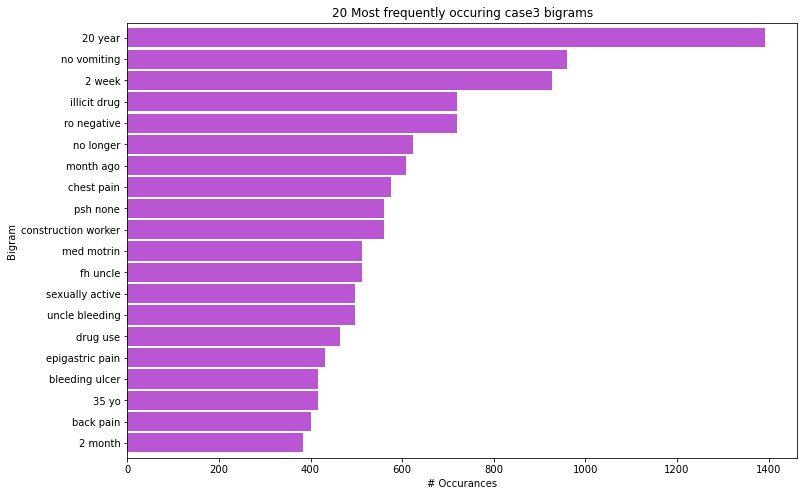

In [41]:
# Calculate Case 0bigrams
case3_bigrams = (pd.Series(nltk.ngrams(case3_words, 2))
                      .value_counts()
                      .head(20))
# Vizualize top case3 Bigrams
case3_bigrams.sort_values().plot.barh(color = 'mediumorchid', width=.9, figsize=(12, 8))

plt.title('20 Most frequently occuring case3 bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = case3_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

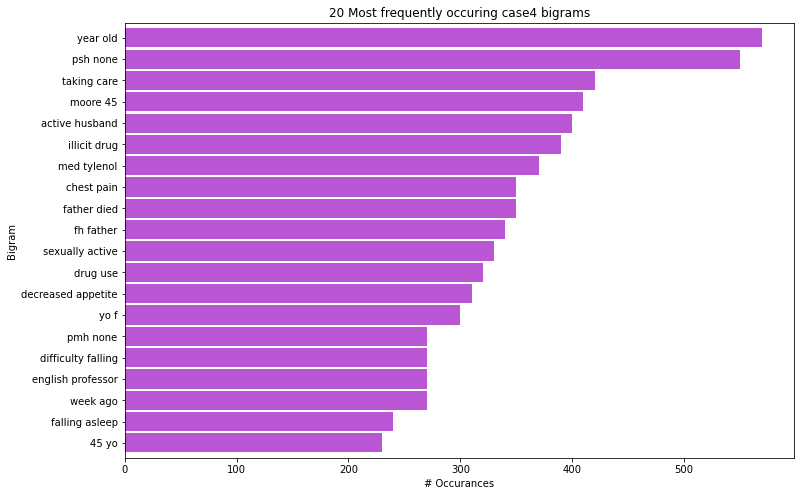

In [42]:
# Calculate Case 0bigrams
case4_bigrams = (pd.Series(nltk.ngrams(case4_words, 2))
                      .value_counts()
                      .head(20))
# Vizualize top case4 Bigrams
case4_bigrams.sort_values().plot.barh(color = 'mediumorchid', width=.9, figsize=(12, 8))

plt.title('20 Most frequently occuring case4 bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = case4_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

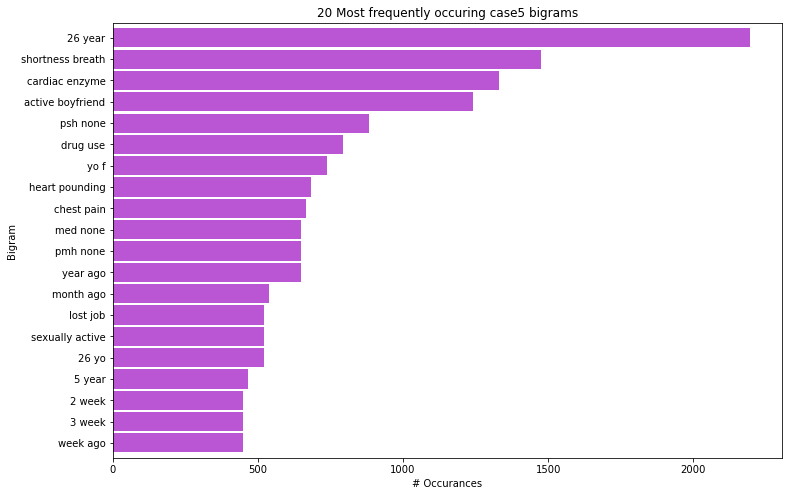

In [43]:
# Calculate Case 0bigrams
case5_bigrams = (pd.Series(nltk.ngrams(case5_words, 2))
                      .value_counts()
                      .head(20))
# Vizualize top case5 Bigrams
case5_bigrams.sort_values().plot.barh(color = 'mediumorchid', width=.9, figsize=(12, 8))

plt.title('20 Most frequently occuring case5 bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = case5_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

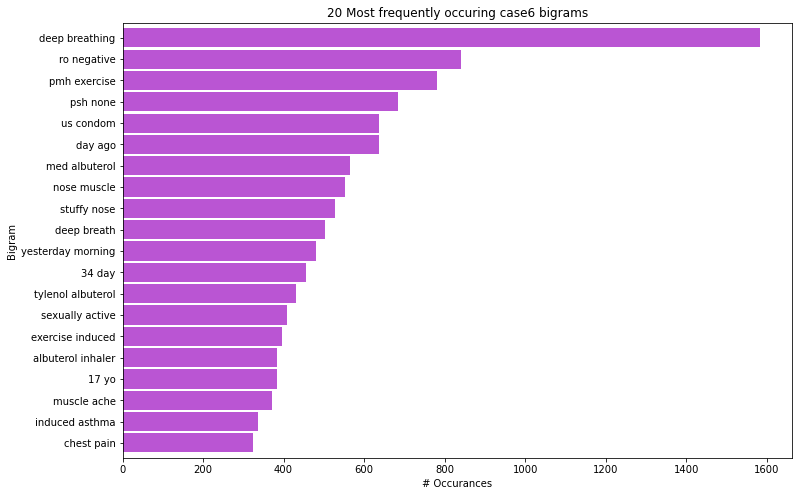

In [44]:
# Calculate Case 0bigrams
case6_bigrams = (pd.Series(nltk.ngrams(case6_words, 2))
                      .value_counts()
                      .head(20))
# Vizualize top case6 Bigrams
case6_bigrams.sort_values().plot.barh(color = 'mediumorchid', width=.9, figsize=(12, 8))

plt.title('20 Most frequently occuring case6 bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = case6_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

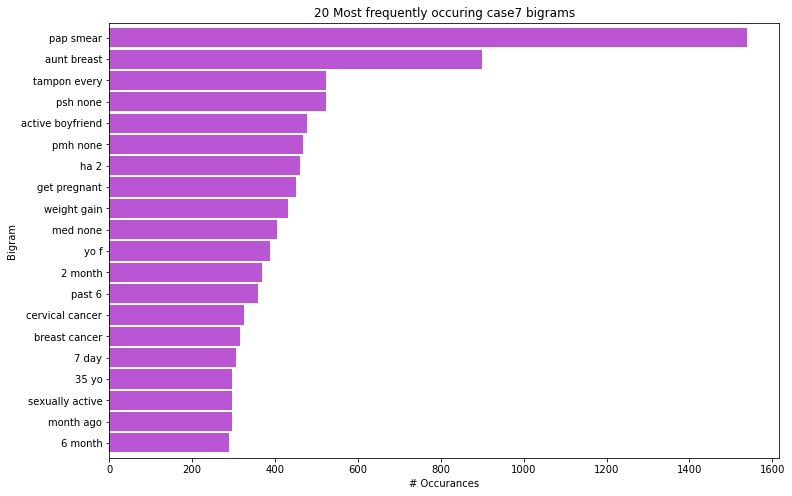

In [45]:
# Calculate Case 0bigrams
case7_bigrams = (pd.Series(nltk.ngrams(case7_words, 2))
                      .value_counts()
                      .head(20))
# Vizualize top case7 Bigrams
case7_bigrams.sort_values().plot.barh(color = 'mediumorchid', width=.9, figsize=(12, 8))

plt.title('20 Most frequently occuring case7 bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = case7_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

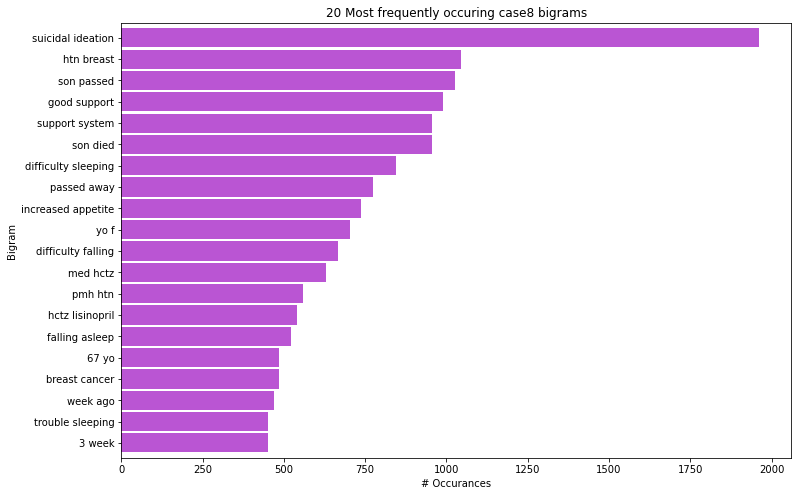

In [46]:
# Calculate Case 0bigrams
case8_bigrams = (pd.Series(nltk.ngrams(case8_words, 2))
                      .value_counts()
                      .head(20))
# Vizualize top case8 Bigrams
case8_bigrams.sort_values().plot.barh(color = 'mediumorchid', width=.9, figsize=(12, 8))

plt.title('20 Most frequently occuring case8 bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = case8_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

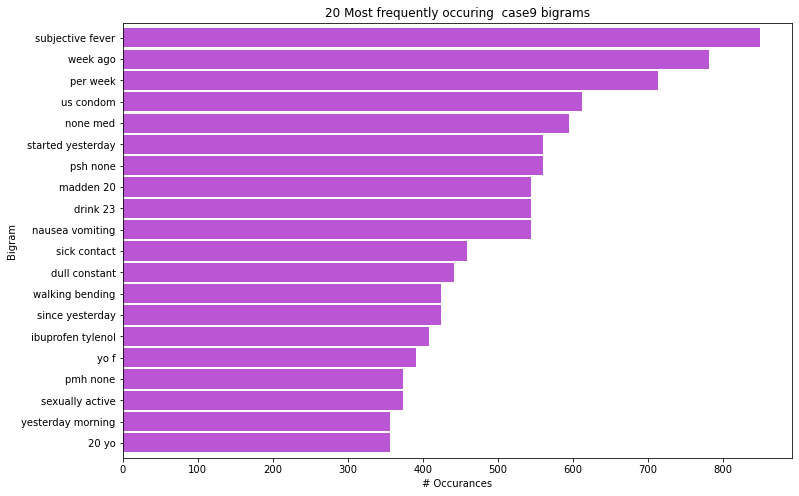

In [48]:
# Calculate Case 0bigrams
case9_bigrams = (pd.Series(nltk.ngrams( case9_words, 2))
                      .value_counts()
                      .head(20))
# Vizualize top  case9 Bigrams
case9_bigrams.sort_values().plot.barh(color = 'mediumorchid', width=.9, figsize=(12, 8))

plt.title('20 Most frequently occuring  case9 bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels =  case9_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)